In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


In [2]:

# Load the dataset
penguins_data = pd.read_csv("penguins.csv")

In [3]:
# Handle the uppercase 'MALE' and 'FEMALE' in the target variable
penguins_data['gender'] = penguins_data['gender'].str.lower()

In [4]:
# Handling NaN values and converting columns to numeric
for col in penguins_data.columns:
    if penguins_data[col].dtype in [np.float64, np.int64]:
        penguins_data[col].fillna(penguins_data[col].mean(), inplace=True)
    else:
        penguins_data[col].fillna(penguins_data[col].mode()[0], inplace=True)


In [5]:
# Convert non-numeric columns to numeric format using one-hot encoding
penguins_data = pd.get_dummies(penguins_data, columns=['species', 'island'], drop_first=True)


In [6]:
# Feature scaling function
def standardize_features(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std == 0] = 1  # Handle zero standard deviation
    return (X - mean) / std


In [7]:
# Create Y and X matrices
Y = penguins_data['gender'].apply(lambda x: 1 if x == 'male' else 0).values
X = penguins_data.drop(columns='gender').values


In [8]:
# Splitting dataset into training and test sets
np.random.seed(0)
indices = np.random.permutation(X.shape[0])
train_size = int(0.8 * X.shape[0])

X_train = X[indices[:train_size]].astype(float)
y_train = Y[indices[:train_size]]

X_test = X[indices[train_size:]].astype(float)
y_test = Y[indices[train_size:]]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (275, 21)
y_train shape: (275,)
X_test shape: (69, 21)
y_test shape: (69,)


In [9]:
# Feature scaling
X_train_std = standardize_features(X_train)
X_test_std = standardize_features(X_test)


In [10]:
# Logistic regression model definition and training
class LogitRegression:
    def __init__(self, learning_rate, iterations, lambda_reg=0.01):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.lambda_reg = lambda_reg
        self.loss = []

    def sigmoid(self, z):
        return np.where(z >= 0, 
                        1 / (1 + np.exp(-z)), 
                        np.exp(z) / (1 + np.exp(z)))

    def cost(self, h, y):
        h = np.clip(h, 1e-10, 1 - 1e-10)
        reg = (self.lambda_reg / (2 * len(y))) * np.sum(self.w**2)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() + reg

    def gradient_descent(self, X, y):
        m = len(y)
        h = self.sigmoid(np.dot(X, self.w))
        gradient = np.dot(X.T, (h - y)) / m
        gradient += (self.lambda_reg / m) * self.w
        self.w -= self.learning_rate * gradient

    def fit(self, X, y):
        self.w = np.random.uniform(0, 1, X.shape[1])
        for i in range(self.iterations):
            h = self.sigmoid(np.dot(X, self.w))
            self.loss.append(self.cost(h, y))
            self.gradient_descent(X, y)

    def predict(self, X):
        return [1 if i >= 0.5 else 0 for i in self.sigmoid(np.dot(X, self.w))]


In [11]:
# Hyperparameters
learning_rates = [1e-2, 1e-3, 5e-4]
lambda_regs = [0.01, 0.05, 0.1]
best_accuracy = 0

for lr in learning_rates:
    for reg in lambda_regs:
        model = LogitRegression(lr, 100000, reg)
        model.fit(X_train_std, y_train)
        y_pred = model.predict(X_test_std)
        accuracy = np.mean(y_pred == y_test)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

print("Best Accuracy:", best_accuracy)


Best Accuracy: 0.8260869565217391


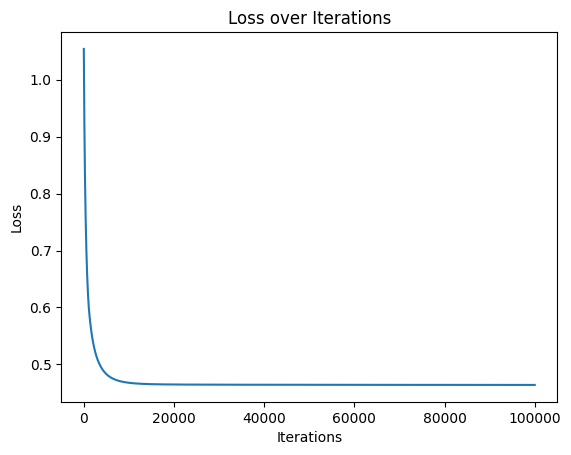

In [77]:
# Plotting the loss graph
plt.plot(best_model.loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

In [ ]:
# Saving the best model weights
with open("best_weights.pkl", "wb") as f:
    pickle.dump(best_model.w, f)